In [353]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import KFold
from itertools import product
from collections import Counter
import itertools
import inspect
from IPython.display import display, clear_output
from Utils import print_args

In [354]:
arr = np.genfromtxt('data/non-parametric.csv', delimiter=';')[1:,:]
xs, ys = arr[:,1:2].copy(), arr[:, 2:].ravel()

In [355]:
def shuffle(X, y):
    p = np.arange(0, X.shape[0])
    np.random.shuffle(p)
    return (X[p], y[p])
xs, ys = shuffle(xs, ys)

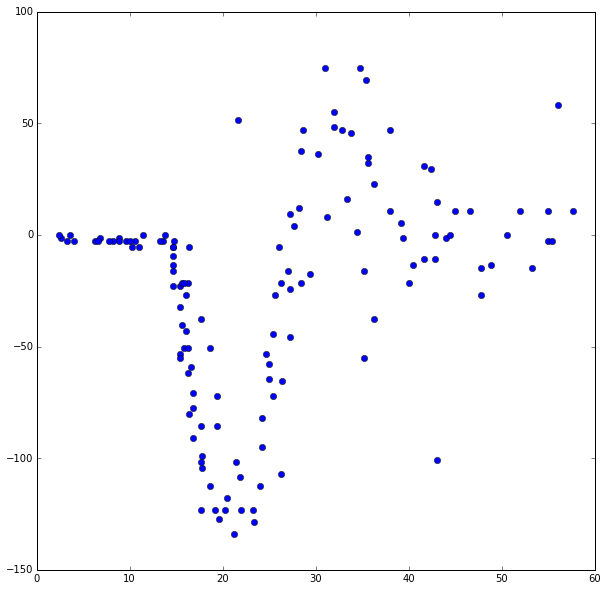

In [356]:
def show(xs, ys):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'bo')
    plt.show()
show(xs, ys)

/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


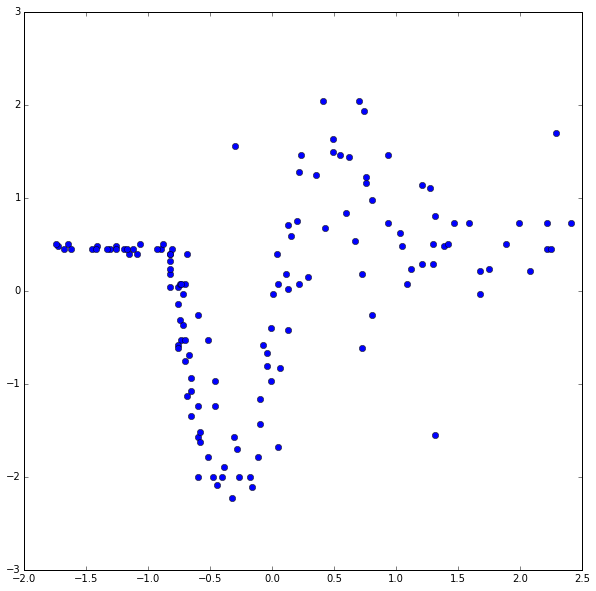

In [357]:
x_scaled = StandardScaler().fit_transform(xs)
y_scaled = StandardScaler().fit_transform(ys)
show(x_scaled, y_scaled)

In [358]:
def kf_cross_validation(regressor, xs, ys, measure, n_fold=10, times=1, verbose=False, **params):
    res = 0
    for _ in range(times):
        kf = KFold(len(xs), n_fold, True, 0)
        kf_sum = 0
        fold_num = 0
        for train_i, test_i in kf:
            regressor.fit(xs[train_i], ys[train_i], **params)
            predicted = np.apply_along_axis(regressor.predict, 1, xs[test_i])
            meas = measure(predicted, ys[test_i])
            fold_num += 1
            kf_sum += meas
            if verbose:
                print("Time {}, fold {} done, error = {}".format(_, fold_num, meas))
        res += kf_sum/n_fold
    if verbose:
        clear_output()
    return res/times

In [359]:
class NadarayaWatsonRegression:
    def fit(self, xs, ys, h, kernel='quad', metric='manh'):
        self.xs = xs
        self.ys = ys
        self.h = h
        if kernel == 'quad':
            self.kernel = lambda x: (15.0/16)*(1-x*x)**2 if (-1.0 <= x <= 1.0) else 0.0
        else:
            self.kernel = kernel
        if metric == 'manh':
            self.metric = lambda x, y: 1.0*abs(x-y).sum()
        else:
            self.metric = metric
        return self
            
    def predict(self, x):
        EPS = 1e-6
        K, po, h = self.kernel, self.metric, self.h
        kerneled = np.apply_along_axis(lambda xi: K(po(xi, x)/h), 1, self.xs)
        if kerneled.sum() < EPS:
            return 0
        return np.dot(kerneled, self.ys)/kerneled.sum()
measure = lambda x, y: ((x-y)**2).mean()
regressor = NadarayaWatsonRegression()

In [360]:
hs = np.arange(0.0, 1.5, 0.05)
mses = []
errors = []
for h in hs:
    mse = kf_cross_validation(regressor, x_scaled, ys, measure, h=h)
    print("h = %.2f, mse = %.2f, eror = %.2f" % (h, mse, np.sqrt(mse)))
    mses.append(mse)
    errors.append(np.sqrt(mse))

h = 0.00, mse = 2999.17, eror = 54.76
h = 0.05, mse = 1318.93, eror = 36.32
h = 0.10, mse = 1086.56, eror = 32.96
h = 0.15, mse = 999.00, eror = 31.61
h = 0.20, mse = 985.21, eror = 31.39
h = 0.25, mse = 982.95, eror = 31.35
h = 0.30, mse = 996.10, eror = 31.56
h = 0.35, mse = 1016.10, eror = 31.88
h = 0.40, mse = 1041.07, eror = 32.27
h = 0.45, mse = 1068.74, eror = 32.69
h = 0.50, mse = 1096.04, eror = 33.11
h = 0.55, mse = 1123.23, eror = 33.51
h = 0.60, mse = 1151.69, eror = 33.94
h = 0.65, mse = 1182.66, eror = 34.39
h = 0.70, mse = 1216.52, eror = 34.88
h = 0.75, mse = 1253.45, eror = 35.40
h = 0.80, mse = 1292.96, eror = 35.96
h = 0.85, mse = 1334.19, eror = 36.53
h = 0.90, mse = 1376.74, eror = 37.10
h = 0.95, mse = 1420.38, eror = 37.69
h = 1.00, mse = 1464.34, eror = 38.27
h = 1.05, mse = 1508.33, eror = 38.84
h = 1.10, mse = 1551.84, eror = 39.39
h = 1.15, mse = 1594.94, eror = 39.94
h = 1.20, mse = 1637.45, eror = 40.47
h = 1.25, mse = 1679.25, eror = 40.98
h = 1.30, mse = 

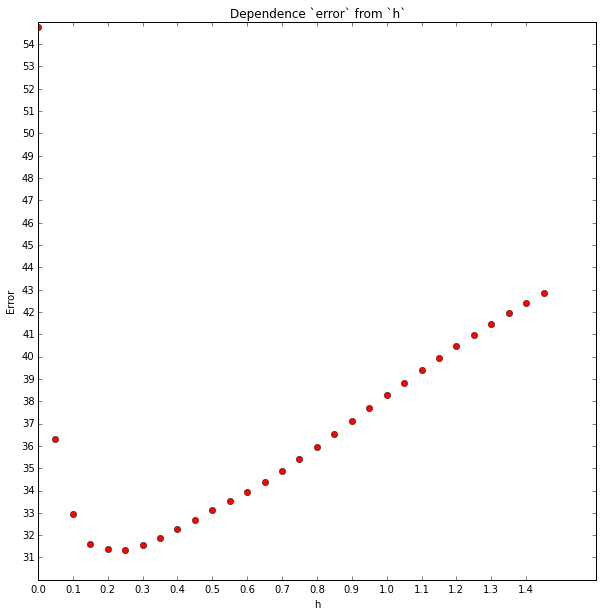

In [361]:
def showError(xs, ys):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'ro')
    plt.xlabel('h')
    plt.ylabel('Error')
    plt.title('Dependence `error` from `h`')
    plt.xticks(np.arange(min(xs), max(xs), 0.1))
    plt.yticks(np.arange(np.floor(min(ys)), np.ceil(max(ys)), 1))
    plt.show()
showError(hs, errors)

In [362]:
regressor.fit(x_scaled, ys, h=0.2)

In [363]:
print("Full dataset train and test")
measure(ys, np.apply_along_axis(regressor.predict, 1, x_scaled))

Full dataset train and test


731.73383601386718

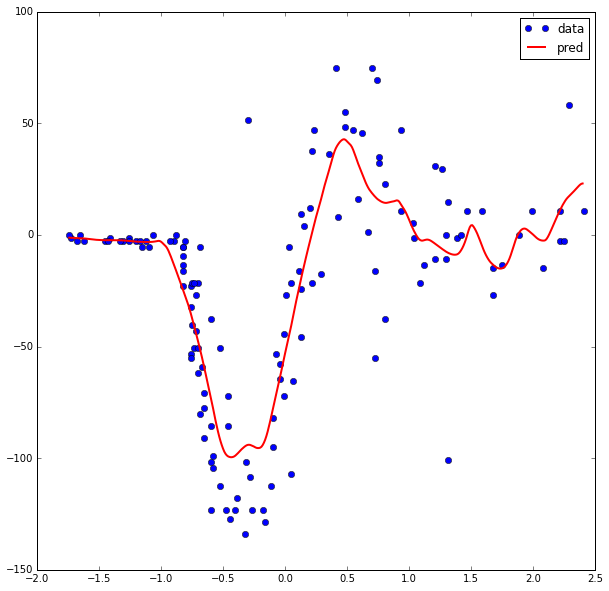

In [364]:
def showDataNPred(xs, ys, lin_x, y_pred):
    plt.figure(figsize=(10, 10))
    label0, = plt.plot(xs, ys, 'bo')
    label1, = plt.plot(lin_x, y_pred, 'r', lw=2)
    plt.legend([label0, label1], ['data', 'pred'])
    plt.show()
x_min, x_max = x_scaled.min(), x_scaled.max()
lin_x = np.resize(np.arange(x_min, x_max, 0.01), (-1, 1))
y_pred = np.apply_along_axis(regressor.predict, 1, lin_x)
showDataNPred(x_scaled, ys, lin_x, y_pred)